In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from collections import deque
from copy import deepcopy
from tqdm import tqdm

In [2]:
class kNN:
    def __init__(self):
        self.k = None
        self.X = None
        self.y = None
        self.classes = None
        self.hyperparameters = None
        self.sectors = None
        self.maxDistance = None
        self.sdt = None
        self.mean = None
        self.Normalized = False
        self.Accuracy = None
        self.data = None
        self.maxi = None
        self.mini = None

    def fit(self, X, y, hyperparameters,mini, maxi, classes = -1,k=1,Normalized=True):
        self.X = np.array(X).astype(float)
        self.y = np.array(y).astype(int)
        self.k = k
        self.hyperparameters = np.array(hyperparameters)
        self.classes = len(np.unique(y)) if (classes == -1) else classes
        self.Normalized = Normalized
        self.maxi = maxi
        self.mini = mini
        if Normalized:
            self.sdt = np.std(X, axis=0)
            self.mean = np.mean(X, axis=0)
            self.X = (self.X-self.mean)/self.sdt

    def neighbors(self,index):
        hyperparameters = self.hyperparameters
        _neighbors = []
        for i in range(len(index)):
            temp = list(index)
            if(index[i] == 0):
                if(hyperparameters[i] == 1):
                    continue
                temp[i] = 1
                _neighbors.append(tuple(temp))
            elif(index[i] == hyperparameters[i]-1):
                temp[i] -= 1
                _neighbors.append(tuple(temp))
            else:
                temp[i] += 1
                _neighbors.append(tuple(temp))
                temp[i] -= 2
                _neighbors.append(tuple(temp))
        return _neighbors

    def radialDistance(self,X,i=0):
        try:
            val = np.sqrt(np.sum(X[:,i:]**2, axis=1))
        except Exception:
            val = np.sqrt(np.sum(X[i:]**2))
        val = np.where(val==0, 1, val)
        return val

    def getPoints(self,hyperparameters):
        arrays = [np.arange(x) for x in self.hyperparameters]
        grid = np.meshgrid(*arrays)
        coord_list = [entry.ravel() for entry in grid]
        points = np.vstack(coord_list).T
        return points

    def sphericalCoordinates(self,X):
        temp = np.zeros(X.shape)
        temp[:, 0] = self.radialDistance(X)
        for i in range(len(X[0])-2):
            temp[:,i+1] = np.arccos(X[:,i]/self.radialDistance(X,i))
        secondLastColumn = X[:,len(X[0])-2]
        lastColumn = X[:,len(X[0])-1]
        temp[:,len(X[0])-1][lastColumn<0] = 2*np.pi - np.arccos(secondLastColumn[lastColumn<0]/self.radialDistance(X[lastColumn<0][:,-2:]))
        temp[:,len(X[0])-1][lastColumn>=0] = np.arccos(secondLastColumn[lastColumn>=0]/self.radialDistance(X[lastColumn>=0][:,-2:]))
        return temp

    def spacePartition(self,X,hyperparameters,predict=False):
        hyperparameters = self.hyperparameters
        epsilon  = 0.000001
        if predict:
            maxDistance = self.maxDistance
        else:
            maxDistance = np.amax(X[:,0])
            self.maxDistance = maxDistance
        temp = np.zeros(X.shape)
        temp[:,0] = np.floor(((hyperparameters[0]*X[:,0])/maxDistance)-epsilon)
        temp[:, 1 : len(hyperparameters) - 1] = np.floor(
            hyperparameters[1:-1] * X[:, 1 : len(hyperparameters) - 1] / np.pi
            - epsilon
        )
        temp[:,-1] = np.floor((hyperparameters[-1]*X[:,-1]/(2*np.pi))-epsilon)
        temp[temp<0] = 0
        return temp.astype(int)

    def getSectors(self,X,y,hyperparameters):
        X = self.sphericalCoordinates(X)
        X = self.spacePartition(X, hyperparameters)
        classes = self.classes
        points = self.getPoints(hyperparameters)
        temp = np.zeros((len(points),classes)).astype(int)
        sectors = dict(zip(map(tuple, points), temp))
        for _x,_y in zip(X,y):
            sectors[tuple(_x)][_y] += 1
        return sectors

    def getClasses(self):
        X = self.X
        y = self.y
        K = self.k
        hyperparameters = self.hyperparameters
        sectors = self.getSectors(X,y,hyperparameters)
        totalSectors = np.prod(hyperparameters)
        classes = {}
        data = {}
        for sector in tqdm(sectors, total=totalSectors, desc="Sectors", unit=" sector"):
            queue = deque()
            results = deepcopy(sectors[sector])
            visited = []
            queue.append(sector)
            k = np.sum(results)
            while(queue and k<K):
                parent = queue.popleft()
                if parent in visited:
                    continue
                visited.append(parent)
                neighbors_ = self.neighbors(parent)
                for neighbor in neighbors_:
                    results+=sectors[neighbor]
                    k = np.sum(results)
                    queue.append(neighbor)
            classes[sector] = np.argmax(results)
            data[sector] = results
        self.data = data
        return classes

    def compile(self):
        self.sectors = self.getClasses()

    def predict(self, X, Preprocessed=False):
        if not Preprocessed:
            for i in range(len(X[0])):
                X[:,i][X[:,i]<self.mini[i]] = self.mini[i]
                X[:,i][X[:,i]>self.maxi[i]] = self.maxi[i]
                X[:,i] = (X[:,i]-self.mini[i])/(self.maxi[i]-self.mini[i])
            X = (X-self.mean)/self.sdt
        y_pred = np.zeros(X.shape[0]).astype(int)
        for i, x in enumerate(X):
            try:
                x = x.reshape(1,-1)
                sphericalCoordinates = self.sphericalCoordinates(x)
                spacePartition = self.spacePartition(sphericalCoordinates, self.hyperparameters,predict=True)
                y_pred[i] = self.sectors[tuple(spacePartition[0])]
            except Exception:
                continue
        return y_pred.astype(int)

    def accuracy(self, X, y):
        if self.Normalized:
            X = (X-self.mean)/self.sdt
        y_pred = self.predict(X, Preprocessed=True)
        self.Accuracy = accuracy_score(y, y_pred)*100
        print(f"Accuracy: {self.Accuracy} %")


    def learn(self, X, Y, Preprocessed=False):
        if self.Normalized and not Preprocessed:
            for i in range(len(X[0])):
                X[:,i][X[:,i]<self.mini[i]] = self.mini[i]
                X[:,i][X[:,i]>self.maxi[i]] = self.maxi[i]
                X[:,i] = (X[:,i]-self.mini[i])/(self.maxi[i]-self.mini[i])
            X = (X-self.mean)/self.sdt
        for x,y in zip(X,Y):
            x = x.reshape(1,-1)
            sphericalCoordinates = self.sphericalCoordinates(x)
            spacePartition = self.spacePartition(sphericalCoordinates, self.hyperparameters,predict=True)
            print("Before data: ",spacePartition[0], self.data[tuple(spacePartition[0])])
            print("Before sectors: ", spacePartition[0], self.sectors[tuple(spacePartition[0])])
            self.data[tuple(spacePartition[0])][y] += 1
            self.sectors[tuple(spacePartition[0])] = np.argmax(self.data[tuple(spacePartition[0])])
            print("After data: ",spacePartition[0], self.data[tuple(spacePartition[0])])
            print("After sectors: ", spacePartition[0], self.sectors[tuple(spacePartition[0])])
            print("Updated")
            
            
    def update(self, models):
        models = np.array(models)
        experiences = np.array([deepcopy(model.data) for model in models])
        for sector in self.sectors:
            for data in experiences:
                data[sector] -= self.data[sector]
            self.data[sector] += np.sum(data[sector] for data in experiences)
            self.sectors[sector] = np.argmax(self.data[sector])
        print("Model Updated")


    def plotConfusionChart(self, X, y, Preprocessed=True):
        y_pred = self.predict(X, Preprocessed=Preprocessed)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

    def showClassificationReport(self, X, y, Preprocessed=True):
        y_pred = self.predict(X, Preprocessed=Preprocessed)
        print(classification_report(y, y_pred, zero_division=0))

    def showCharts(self, X, y):
        self.plotConfusionChart(X,y)
        self.showClassificationReport(X,y)


def saveModel(model, name):
    with open(name, 'wb') as file:
        pickle.dump(model, file)

def loadModel(name):
    with open(name, 'rb') as file:
        return pickle.load(file)

# Evaluation Metrics for Classification
1. Accuracy -> (TP+TN)/(TP+TN+FP+FN) -> Ratio of correct predictions to total predictions
2. Precision -> TP/(TP+FP) -> Ratio of correct positive predictions to total positive predictions
3. Recall -> TP/(TP+FN) -> Ratio of correct positive predictions to total positive actual positive values
4. F1 Score -> 2*(Precision*Recall)/(Precision+Recall) -> Harmonic mean of precision and recall



# IRIS DATASET

In [3]:
# Preprocessing the dataset
np.random.seed(42)
df = pd.read_csv(r'Datasets\\Iris.csv', header=None).iloc[1:,1:]
classes = np.sort(np.unique(df.iloc[1:, -1].values))
df.replace('Iris-setosa', 0, inplace=True)
df.replace('Iris-versicolor', 1, inplace=True)
df.replace('Iris-virginica', 2, inplace=True)
y = df.iloc[:,-1].values
df = df.iloc[:,:-1]
X = df.values.astype(float)
mini = np.zeros(len(X[0]))
maxi = np.zeros(len(X[0]))
for i in range(len(X[0])):
    mini[i] = np.min(X[:,i])
    maxi[i] = np.max(X[:,i])
    X[:,i] = (X[:,i] - np.min(X[:,i]))/(np.max(X[:,i]) - np.min(X[:,i]))
    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
HYPERPARAMETERS__IRIS = [8,8,8,8]

In [4]:
model_IRIS = kNN()
model_IRIS.fit(x_train, y_train, HYPERPARAMETERS__IRIS,mini,maxi, classes=3,k=1)
model_IRIS.compile()

Sectors: 100%|████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:17<00:00, 233.15 sector/s]


In [5]:
model_IRIS.predict(np.array([5.9,3.2,4.8,1.8]).reshape(1,-1))

array([1])

In [6]:
model_IRIS.accuracy(x_test, y_test)

Accuracy: 100.0 %


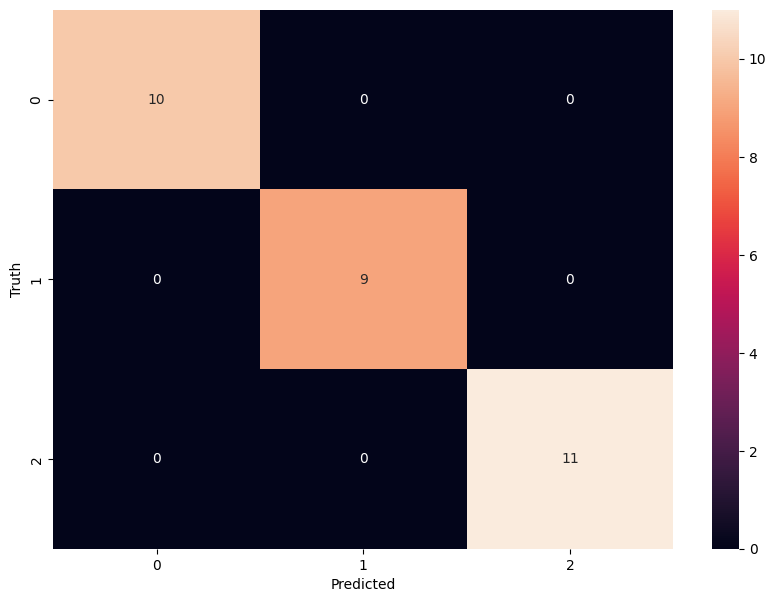

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [7]:
model_IRIS.showCharts(x_test, y_test)

In [8]:
x = np.array([6.8,3.2,5.9,2.3]).reshape(1,-1)
model_IRIS.predict(x)

array([2])

## Federated Learning

In [9]:
model_IRIS.learn(np.array([6.8,3.2,5.9,2.3]).reshape(1,-1), np.array([1]).reshape(1,-1))

Before data:  [3 2 3 1] [0 0 5]
Before sectors:  [3 2 3 1] 2
After data:  [3 2 3 1] [0 1 5]
After sectors:  [3 2 3 1] 2
Updated


### Iris Dataset

| No of sectors | Prediction Accuracy | Model size (in MB) | Training time (s) | Prediction time (s) | Learning time (s) |
|--------------|--------------------|---------------------|-------------------|---------------------|-------------------|
| 1            | 33.33%             | 0.0047              | 0.0086            | 0.00150             | 0.001             |
| 4            | 82.66%             | 0.0050              | 0.0048            | 0.00050             | 0.001             |
| 16           | 85.33%             | 0.0065              | 0.0097            | 0.00048             | 0.001             |
| 64           | 88.00%             | 0.0124              | 0.0116            | 0.00102             | 0.001             |
| 256          | 93.33%             | 0.0360              | 0.0356            | 0.00103             | 0.002             |
| 1024         | 96.66%             | 0.1305              | 0.8023            | 0.00079             | 0.001             |
| 4096         | 98.66%             | 0.5085              | 20.4194           | 0.00237             | 0.001             |
| 16384        | 98.0%              | 2.0206              | 375.5257           | 0.0010              | 0.001             |

# SHUTTLE DATASET

In [10]:
df = pd.read_csv(r'Datasets\\shuttle.csv', header=None).iloc[1:, :].values
X = df[:, :-1].astype(float)
Y = df[:, -1].astype(int)-1
mini = np.zeros(len(X[0]))
maxi = np.zeros(len(X[0]))
for i in range(len(X[0])):
    mini[i] = np.min(X[:,i])
    maxi[i] = np.max(X[:,i])
    X[:,i] = (X[:,i] - np.min(X[:,i]))/(np.max(X[:,i]) - np.min(X[:,i]))
    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
HYPERPARAMETERS__SHUTTLE = np.array([2,2,2,2,2,2,2,2,2])

In [11]:
model_SHUTTLE = kNN()
model_SHUTTLE.fit(X_train, Y_train, HYPERPARAMETERS__SHUTTLE,mini,maxi, classes=7,k=1)
model_SHUTTLE.compile()

Sectors: 100%|████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 17645.57 sector/s]


In [12]:
model_SHUTTLE.accuracy(X_test, Y_test)

Accuracy: 91.79310344827586 %


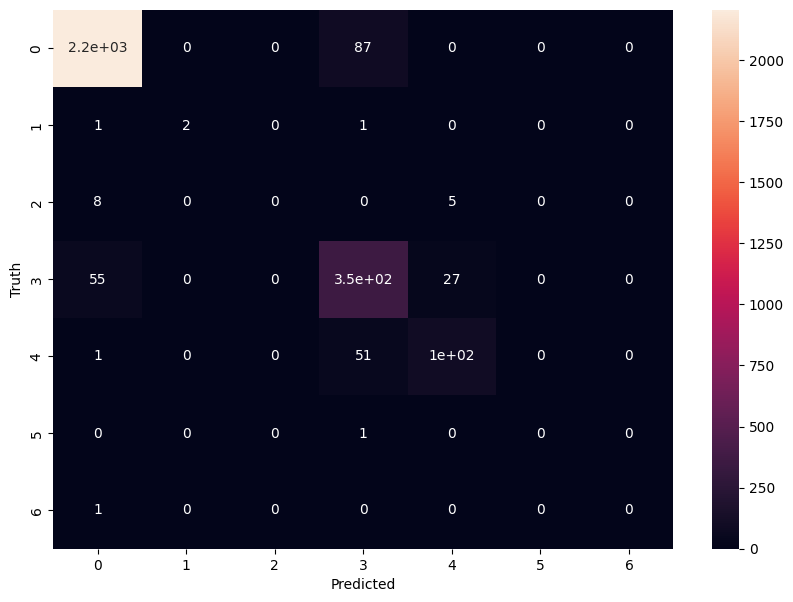

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2293
           1       1.00      0.50      0.67         4
           2       0.00      0.00      0.00        13
           3       0.72      0.81      0.76       436
           4       0.76      0.66      0.70       152
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.92      2900
   macro avg       0.49      0.42      0.44      2900
weighted avg       0.92      0.92      0.92      2900



In [13]:
model_SHUTTLE.showCharts(X_test, Y_test)

## Federated Learning

In [14]:
model_SHUTTLE.learn(np.array([37,-51,106,-1,34,-1,69,72,4]).reshape(1,-1), np.array([1]).reshape(1,-1))

Before data:  [0 1 1 0 0 0 0 0 1] [53  0  0  0  0  0  0]
Before sectors:  [0 1 1 0 0 0 0 0 1] 0
After data:  [0 1 1 0 0 0 0 0 1] [53  1  0  0  0  0  0]
After sectors:  [0 1 1 0 0 0 0 0 1] 0
Updated


### Shuttle Dataset

| No of sectors | Prediction Accuracy | Model size (in MB) | Training time (s) | Prediction time (s) | Learning time (s) |
|--------------|--------------------|---------------------|-------------------|---------------------|-------------------|
| 1            | 79.06%             | 0.8416              | 0.0311            | 0.0015              | 0.001             |
| 4            | 79.17%             | 0.8422              | 0.0283            | 0.0009              | 0.001             |
| 16           | 79.21%             | 0.8447              | 0.02310           | 0.0012              | 0.002             |
| 64           | 87.96%             | 0.8548              | 0.02779           | 0.0008              | 0.001             |
| 256          | 89.86%             | 0.8591              | 0.03643           | 0.0014              | 0.001             |
| 1024         | 91.79%             | 1.0563              | 0.60432           | 0.0012              | 0.001             |
| 4096         | 91.88%             | 1.7009              | 6.7168            | 0.0011              | 0.002             |
| 16384        | 94.57%             | 4.2794              | 45.0785           | 0.0003              | 0.0002            |


# WI-FI DATASET

In [15]:
df = pd.read_csv(r'Datasets\\wifi.csv', header=None).iloc[1:,1:].astype(int)
y = df.iloc[:,-1].values.astype(int) - 1
X = df.values.astype(float)
mini = np.zeros(len(X[0]))
maxi = np.zeros(len(X[0]))
for i in range(len(X[0])):
    mini[i] = np.min(X[:,i])
    maxi[i] = np.max(X[:,i])
    X[:,i] = (X[:,i] - np.min(X[:,i]))/(np.max(X[:,i]) - np.min(X[:,i]))
    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
HYPERPARAMETERS__WIFI = [4,4,4,4,4,4,4]
classes = len(np.unique(y))

In [16]:
model_WIFI = kNN()
model_WIFI.fit(x_train, y_train, HYPERPARAMETERS__WIFI,mini,maxi, classes=classes,k=1)
model_WIFI.compile()

Sectors: 100%|██████████████████████████████████████████████████████████████████████████| 16384/16384 [00:39<00:00, 411.29 sector/s]


In [17]:
model_WIFI.accuracy(x_test, y_test)

Accuracy: 98.5 %


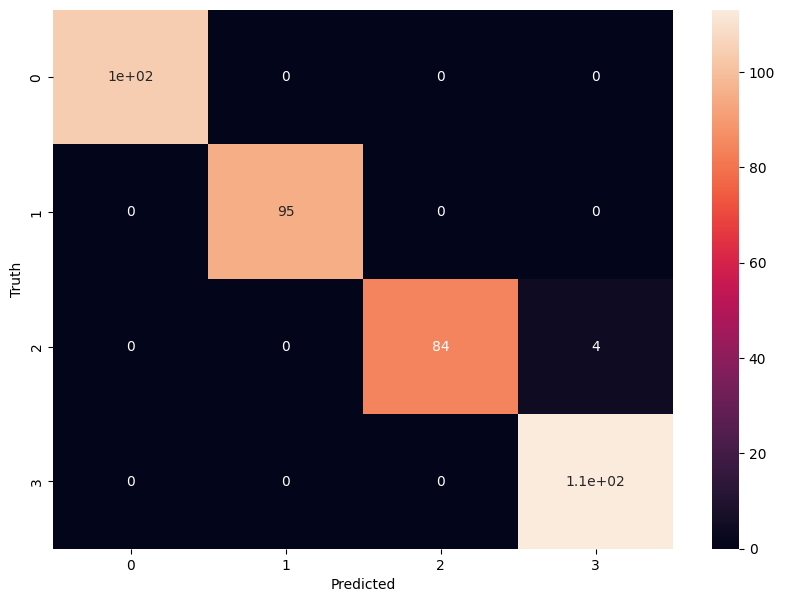

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        95
           2       1.00      0.95      0.98        88
           3       0.97      1.00      0.98       113

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [18]:
model_WIFI.showCharts(x_test, y_test)

## Federated Learning

In [19]:
model_WIFI.learn(np.array([-58,-51,-56,-58,-50,-88,-88]).reshape(1,-1), np.array([3]).reshape(1,-1))

Before data:  [0 1 2 2 1 0 1] [0 0 1 0]
Before sectors:  [0 1 2 2 1 0 1] 2
After data:  [0 1 2 2 1 0 1] [0 0 1 1]
After sectors:  [0 1 2 2 1 0 1] 2
Updated


### Wi-Fi Dataset

| No of sectors | Prediction Accuracy | Model size (in MB) | Training time (s) | Prediction time (s) | Learning time (s) |
|--------------|--------------------|---------------------|-------------------|---------------------|-------------------|
| 1            | 25.0%              | 0.0923              | 0.0049            | 0.0002              | 0.0001            |
| 4            | 79.05%             | 0.0928              | 0.0040            | 0.0010              | 0.00009           |
| 16           | 97.3%              | 0.0949              | 0.0040            | 0.0003              | 0.00009           |
| 64           | 97.6%              | 0.1030              | 0.0050            | 0.0009              | 0.0001            |
| 256          | 97.95%             | 0.1356              | 0.0099            | 0.0002              | 0.00009           |
| 1024         | 98.05%             | 0.2660              | 0.0615            | 0.0003              | 0.0001            |
| 4096         | 98.35%             | 0.7876              | 1.2837            | 0.0010              | 0.00009           |
| 16384        | 99.3%              | 2.8738              | 26.7988           | 0.0010              | 0.0001            |


# HTRU DATASET

In [20]:
df = pd.read_csv(r'Datasets\\HTRU_2.csv', header=None).iloc[:,:].values
X = df[:, :-1].astype(float)
Y = df[:, -1].astype(int)
mini = np.zeros(len(X[0]))
maxi = np.zeros(len(X[0]))
for i in range(len(X[0])):
    mini[i] = np.min(X[:,i])
    maxi[i] = np.max(X[:,i])
    X[:,i] = (X[:,i] - np.min(X[:,i]))/(np.max(X[:,i]) - np.min(X[:,i]))
    X[:,i] = (X[:,i] - np.mean(X[:,i]))/np.std(X[:,i])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
HYPERPARAMETERS__HTRU = np.array([2,2,2,2,2,2,2,2])

In [21]:
model_HTRU = kNN()
model_HTRU.fit(X_train, Y_train, HYPERPARAMETERS__HTRU, mini,maxi, classes=2,k=1)
model_HTRU.compile()

Sectors: 100%|████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 18248.50 sector/s]


In [22]:
model_HTRU.accuracy(X_test, Y_test)

Accuracy: 97.37430167597766 %


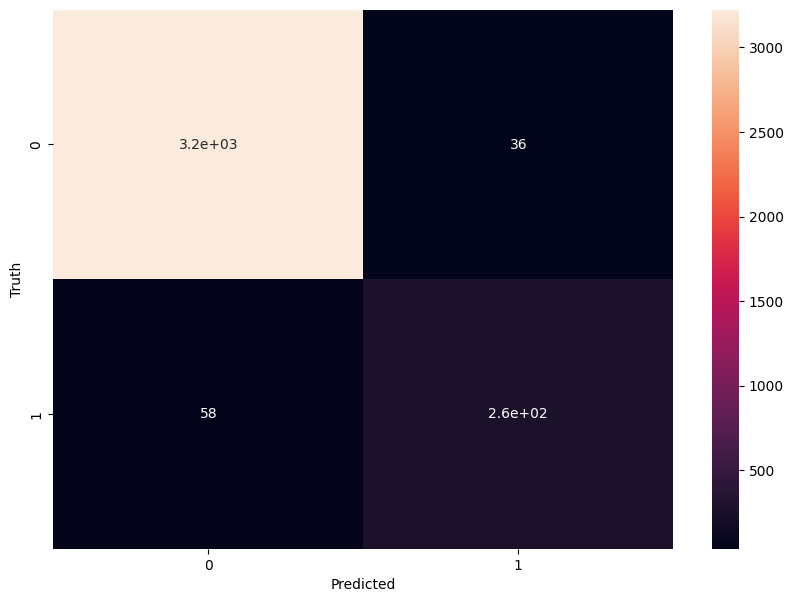

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3259
           1       0.88      0.82      0.85       321

    accuracy                           0.97      3580
   macro avg       0.93      0.90      0.92      3580
weighted avg       0.97      0.97      0.97      3580



In [23]:
model_HTRU.showCharts(X_test, Y_test)

## Federated Learning

In [24]:
model_HTRU.learn(np.array([140.6796875,44.57874592,0.013023756,0.385921041,4.940635452,25.57445006,5.603603749,32.8049201]).reshape(1,-1), np.array([1]).reshape(1,-1))


Before data:  [0 0 0 0 0 0 0 0] [15 76]
Before sectors:  [0 0 0 0 0 0 0 0] 1
After data:  [0 0 0 0 0 0 0 0] [15 77]
After sectors:  [0 0 0 0 0 0 0 0] 1
Updated


### HTRU Dataset

| No of sectors | Prediction Accuracy | Model size (in MB) | Training time (s) | Prediction time (s) | Learning time (s) |
|--------------|--------------------|---------------------|-------------------|---------------------|-------------------|
| 1            | 90.84%             | 0.8200              | 0.0319            | 0.0006              | 0.001             |
| 4            | 93.06%             | 0.8205              | 0.0263            | 0.0008              | 0.001             |
| 16           | 93.91%             | 0.8224              | 0.0275            | 0.0010              | 0.001             |
| 64           | 97.20%             | 0.8302              | 0.0294            | 0.0010              | 0.001             |
| 256          | 97.51%             | 0.8613              | 0.0414            | 0.0005              | 0.001             |
| 1024         | 97.72%             | 0.9859              | 0.2608            | 0.0007              | 0.002             |
| 4096         | 97.76%             | 1.4840              | 4.6422            | 0.0008              | 0.001             |
| 16384        | 97.85%             | 3.4765              | 66.1641           | 0.0004              | 0.0001            |


## Saving and Loading models

In [25]:
saveModel(model_HTRU, "models\\model_HTRU.sav")

LoadedModel_HTRU = loadModel("models\\model_HTRU.sav")

LoadedModel_HTRU.accuracy(X_test, Y_test)

Accuracy: 97.37430167597766 %
